# YOLO based object detection model from scratch for detectiong wheat heads

Implement a object detection head from scratch that can be attached to a pretrained  model for detecting wheat heads. First, make the necessary imports.

In [13]:
import os
import numpy as np
import pandas as pd
import re

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For Image Augmentation
import albumentations as albu
from PIL import Image,ImageDraw
from tqdm import tqdm


# For Object Detection
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras


Read the dataset csv file containing the labels

In [2]:
train=pd.read_csv('./train.csv')

Show first five entries

In [3]:
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


Extract the box coordinates into separate columns

In [6]:
train['x_min']=train['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[0])[0]))
train['y_min']=train['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[1])[0]))
train['box_width']=train['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[2])[0]))
train['box_height']=train['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[3])[0]))

Calculate x_max and y_max

In [7]:
train.drop('bbox',axis=1,inplace=True)
train['box_area']=train['box_width']*train['box_height']
train['x_max']=train['x_min']+train['box_width']
train['y_max']=train['y_min']+train['box_height']
train

,image_id,width,height,source,x_min,y_min,box_width,box_height,box_area,x_max,y_max
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0,2016.0,890.0,258.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0,7540.0,356.0,606.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0,11840.0,451.0,664.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0,11663.0,943.0,202.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0,14508.0,150.0,261.0
...,...,...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0,7980.0,148.0,714.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0,8774.0,399.0,631.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0,10011.0,275.0,299.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0,14536.0,614.0,92.0


## Exploratory Data Analysis

In [16]:
def show_images(df,rows,cols,title,linecolor):
    """ Function to show images with detected objects"""
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            images=df.iloc[idx].image_id

            path=os.path.join('train',images+'.jpg')
            image=Image.open(path)

            objects=train[train['image_id']==images][['x_min','x_max','y_min','y_max']].values
            # Drawing on the Image
            draw=ImageDraw.Draw(image)

            for box in objects:
                draw.rectangle([box[0],box[2],box[1],box[3]],width=10,outline=linecolor)
            plt.figure(figsize=(10,10))
            axs[row,col].imshow(image)
            axs[row,col].axis('off')
    plt.suptitle(title)

Count the number of boxes in each image

In [9]:
train['count']=train.apply(lambda row: 1 if np.isfinite(row.box_width) else 0, axis=1)
train_images_spikes= train.groupby('image_id')['count'].sum().reset_index()
np.max(train_images_spikes['count'])

116

Display histogram of the bounding boxes count distribution

In [14]:
# Visualizing Spikes
counts,bins=np.histogram(train_images_spikes['count'],bins=range(0,117,4))
labels=[]
for i in range(0,len(bins)-1):
    labels.append(f'({bins[i]}-{bins[i+1]})')
px.bar(x=labels,y=counts,labels={'x':'Range of Wheats per Images','y':'count'},title="Number of wheat spikes per image")

Also, display the images with a high number of boxes

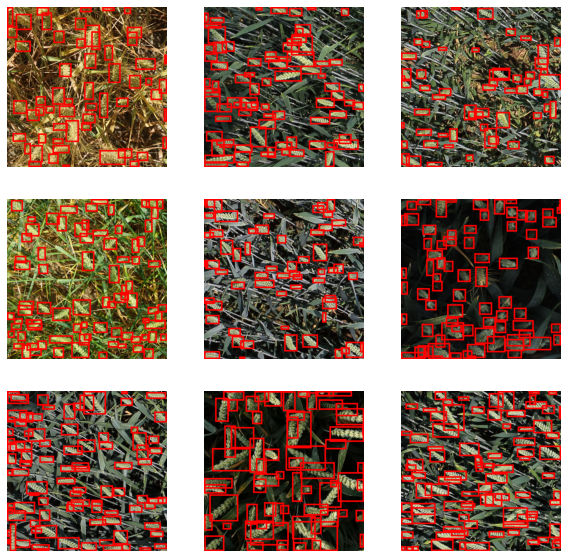

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [17]:
show_images(train_images_spikes[train_images_spikes['count']>50],3,3,'Images with Higher Spikes','red')

Visualize the distribution of bounding box area across the dataset

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='box_area'>

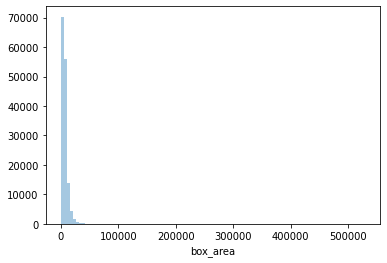

In [18]:
sns.distplot(train['box_area'],kde=False,bins=100)


Show images with large bounding boxes

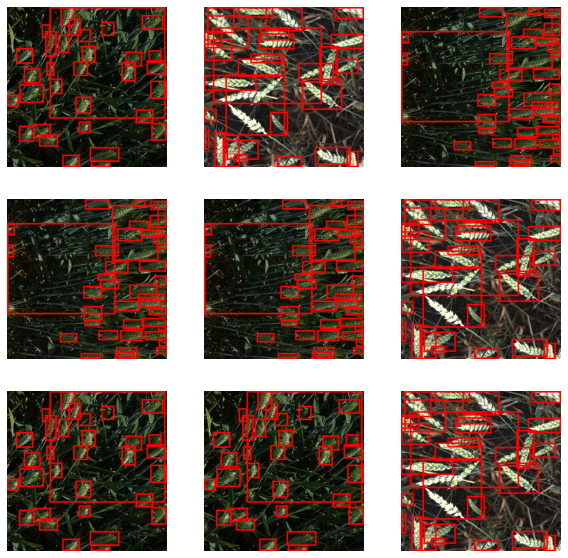

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [19]:
show_images(train[train['box_area']>300000],3,3,'Images with large bounding box','red')

It can be observed that most of the bounding boxes with a large area are not really that relevant. The deep learning model can easily figure that out but to make things easier, we are going to filter them out.

In [20]:
train.box_area.sort_values(ascending = False)
train = train[train['box_area']<400000]

## Loading data and defining the model

First, we are going to resize the individual images and load them onto memory along with their respective labels before splitting into a train set and a validation set

In [21]:
train_image_ids = np.unique(train['image_id'].values)[0:3363]
val_image_ids = np.unique(train['image_id'].values)[3363:3373]

In [22]:
def load_image(image_id):
    image = Image.open('./train/' + image_id + ".jpg")
    image = image.resize((256, 256))
    
    return np.asarray(image)

In [23]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = train[train['image_id']==image_id][['x_min','y_min','box_width','box_height']].values/4
#train_labels#[image_id] = labels[image_id].copy() / 4

100%|██████████| 3363/3363 [01:03<00:00, 53.01it/s]


In [24]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = train[train['image_id']==image_id][['x_min','y_min','box_width','box_height']].values/4

100%|██████████| 10/10 [00:00<00:00, 20.59it/s]


Define a function to draw the boxes

In [28]:
def draw_bboxes(image_id, bboxes, source='train'):  
    image = Image.open('./' + source +'/' + image_id + ".jpg")
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')

Define a function to show the images with their bounding boxes

In [29]:
def show_images(image_ids, bboxes, source='train'):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id], source)
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

Display a sample of the training data

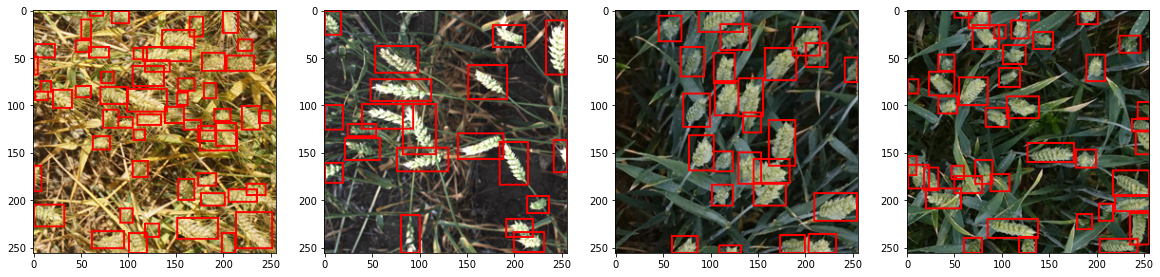

In [30]:
show_images(train_image_ids[0:4], train_labels)

Define the data generator for training the model and also form an image grid

In [31]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 256 / 32, 256 / 32] 

        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid

Define the length of each batch and an on_epoch_end function to suffle the data after each epoch

In [32]:
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

The images in our dataset show colour variations and lighting variations therefore, we enhance the contrast and convert the images to gray scale for better results on both the train and valiadation sets. On the train set, we apply some additional data augmentation methods.

In [33]:
DataGenerator.train_augmentations = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=256, 
            width=256, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise(),
            albu.GlassBlur(),
            albu.ISONoise(),
            albu.MultiplicativeNoise(),
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

/usr/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning:

Cutout has been deprecated. Please use CoarseDropout



Putting things together and define the getitem and data_generation methods

In [34]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

Form a label grid using two anchor boxes so a to return the labels in the required YOLO format as the boxes are given in coco format.

In [35]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

Declare the train and validation data loaders

In [36]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=6, 
    shuffle=True,
    augment=True
)
val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=10,
    shuffle=False,
    augment=False
)
image_grid = train_generator.image_grid

Next, we import a pre-trained ResNet50 model from keras and then we write our object detection that consists of a bunch of convulution layers.

In [37]:
#x_input = tf.keras.Input(shape=(1024,1024,3))
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top = False, weights = "imagenet", input_shape = (256, 256, 3))
resnet50.trainable = True
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(resnet50.layers[-122].output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)
model = tf.keras.Model(inputs=resnet50.input, outputs=predictions)
predictions

2022-11-02 13:08:23.764280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-02 13:08:23.764312: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-02 13:08:23.764334: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rajarshi-EEE): /proc/driver/nvidia/version does not exist
2022-11-02 13:08:23.764537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94765736/94765736 [==============================] - 2s 0us/step


<KerasTensor: shape=(None, 32, 32, 10) dtype=float32 (created by layer 'conv2d_3')>

The loss function for training the model consists of two parts. The first one is the binary crossentropy loss which used to classify whether a cell contains an object or not. Then, we also have mean square error loss for the regression task of predicting the box coordinates. Also, in a cell if an achor box contains an object then its weightage is increased 5 times otherwise it is reduces by half.

In [38]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

Define the optimizer and complile the model

In [39]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

Set callbacks

In [40]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
]

Train the model

In [41]:
history = model.fit(
    train_generator,
    validation_data=train_generator,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
560/560 [==============================] - 491s 873ms/step - loss: 0.2855 - val_loss: 0.1567 - lr: 1.0000e-04
Epoch 2/20
560/560 [==============================] - 442s 789ms/step - loss: 0.0930 - val_loss: 0.0881 - lr: 1.0000e-04
Epoch 3/20
560/560 [==============================] - 448s 799ms/step - loss: 0.0697 - val_loss: 0.0668 - lr: 1.0000e-04
Epoch 4/20
560/560 [==============================] - 466s 833ms/step - loss: 0.0614 - val_loss: 0.0591 - lr: 1.0000e-04
Epoch 5/20
560/560 [==============================] - 452s 807ms/step - loss: 0.0576 - val_loss: 0.0584 - lr: 1.0000e-04
Epoch 6/20
560/560 [==============================] - 441s 787ms/step - loss: 0.0558 - val_loss: 0.0547 - lr: 1.0000e-04
Epoch 7/20
560/560 [==============================] - 436s 778ms/step - loss: 0.0543 - val_loss: 0.0532 - lr: 1.0000e-04
Epoch 8/20
560/560 [==============================] - 436s 778ms/step - loss: 0.0532 - val_loss: 0.0522 - lr: 1.0000e-04
Epoch 9/20
560/560 [============

The next task is to take the predictions from the model and convert them to the bounding box format. For this we select the boxes with a higher probability score and then eliminate redundant boxes using non-max suppression.

In [42]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

Define non-max suppression method and some helper functions

In [43]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes = switch_x_y(bboxes)
    print(bboxes.shape)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    print(bboxes.shape)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:,0].copy()
    y1 = bboxes[:,1].copy()
    x2 = bboxes[:,2].copy()
    y2 = bboxes[:,3].copy()
    
    bboxes[:,0] = y1
    bboxes[:,1] = x1
    bboxes[:,2] = y2
    bboxes[:,3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

Incorporate everything into a single function and convert the boxes back to coco format.

In [44]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

Validating the model

In [45]:
val_predictions = model.predict(val_generator)
val_predictions = process_predictions(val_predictions, val_image_ids, image_grid)

1/1 [==============================] - 1s 819ms/step
(2048, 4)
(22, 4)
(2048, 4)
(2, 4)
(2048, 4)
(20, 4)
(2048, 4)
(57, 4)
(2048, 4)
(32, 4)
(2048, 4)
(45, 4)
(2048, 4)
(30, 4)
(2048, 4)
(27, 4)
(2048, 4)
(31, 4)
(2048, 4)
(23, 4)


Show the model outcome on validation set

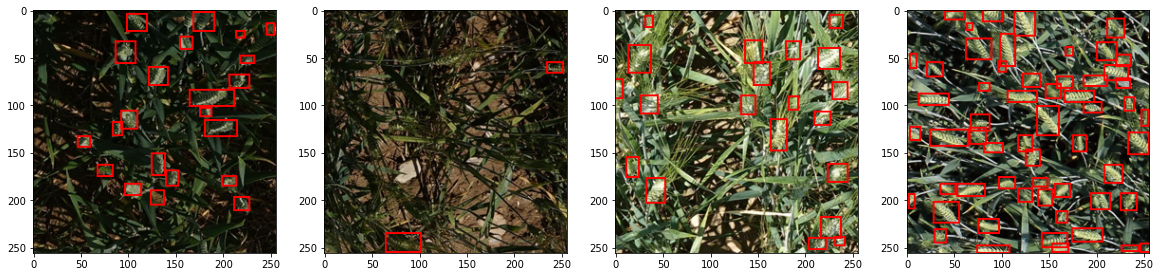

In [46]:
show_images(val_image_ids[0:4], val_predictions)

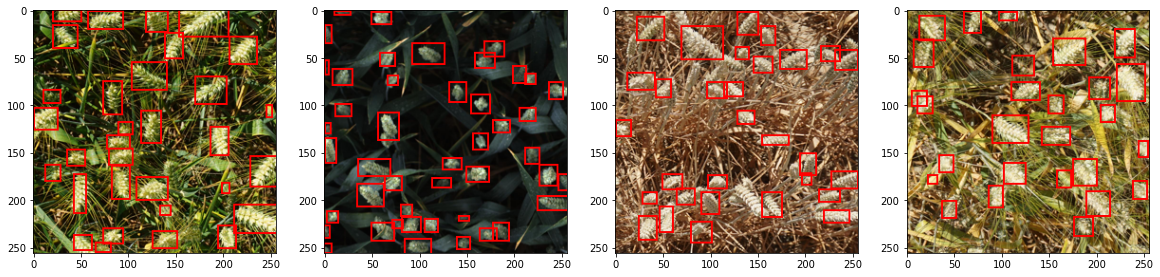

In [47]:
show_images(val_image_ids[4:8], val_predictions)

Save and zip the model

In [30]:
model.save('model')

2022-09-30 13:55:27.036219: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [32]:
!zip -r zipfile.zip model

updating: model/ (stored 0%)
updating: model/assets/ (stored 0%)
updating: model/saved_model.pb (deflated 92%)
updating: model/variables/ (stored 0%)
updating: model/variables/variables.index (deflated 79%)
updating: model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: model/keras_metadata.pb (deflated 94%)


Plot the training and validation loss curves

In [48]:
print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str(history.history['loss'][-1]))
print('Final validation loss: ' + str(history.history['val_loss'][-1]))

Epochs: 20
Final training loss: 0.04879707098007202
Final validation loss: 0.04867357015609741


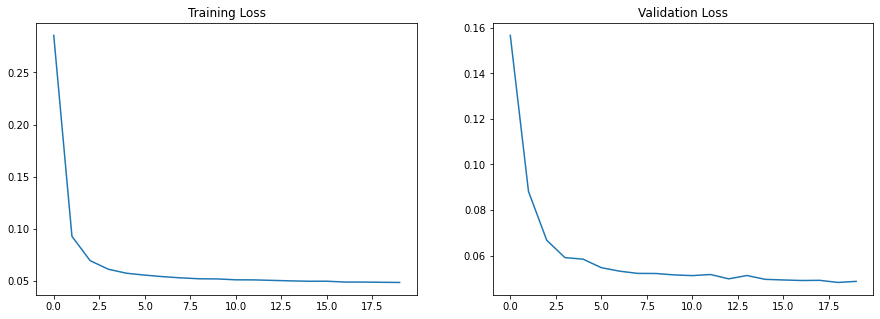

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])